In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import requests
import torch.optim as optim
from io import StringIO
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/diabetes.csv"
response = requests.get(url)
data = StringIO(response.text)

df = pd.read_csv(data)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: ylabel='count'>

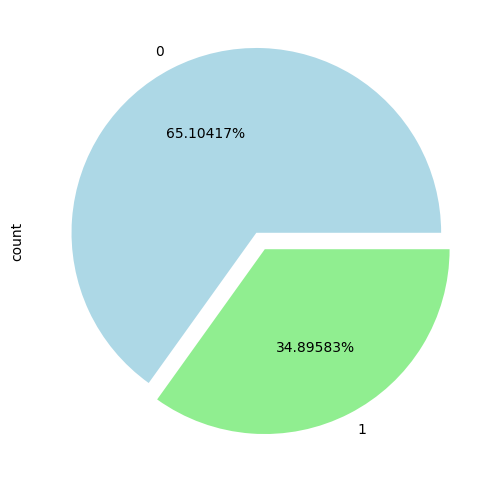

In [51]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
counts = df.Outcome.value_counts()
explode = [0.05] * len(counts)

counts.plot(
    kind='pie',
    autopct='%0.05f%%',
    colors=['lightblue', 'lightgreen', 'orange', 'pink'],
    explode=explode
)


In [52]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [53]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [54]:
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

In [55]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [57]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [58]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

In [60]:
class diabetesDense(nn.Module):
    def __init__(self):
        super(diabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # 2개 - 당뇨 인지 / 아닌지
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = diabetesDense()

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [62]:
train_losses = []
test_accuracies = []

#학습 반복
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad() #기울기 초기화

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")
print(X_train.shape, y_train.shape)

Epoch 1/30, Loss: 0.5519, Accuracy: 78.57%
Epoch 2/30, Loss: 0.4742, Accuracy: 79.22%
Epoch 3/30, Loss: 0.4624, Accuracy: 79.87%
Epoch 4/30, Loss: 0.4584, Accuracy: 81.17%
Epoch 5/30, Loss: 0.4452, Accuracy: 80.52%
Epoch 6/30, Loss: 0.4379, Accuracy: 80.52%
Epoch 7/30, Loss: 0.4338, Accuracy: 81.82%
Epoch 8/30, Loss: 0.4256, Accuracy: 81.82%
Epoch 9/30, Loss: 0.4162, Accuracy: 79.87%
Epoch 10/30, Loss: 0.4111, Accuracy: 80.52%
Epoch 11/30, Loss: 0.4041, Accuracy: 79.87%
Epoch 12/30, Loss: 0.3968, Accuracy: 79.22%
Epoch 13/30, Loss: 0.3897, Accuracy: 79.87%
Epoch 14/30, Loss: 0.3769, Accuracy: 79.87%
Epoch 15/30, Loss: 0.3760, Accuracy: 79.22%
Epoch 16/30, Loss: 0.3772, Accuracy: 78.57%
Epoch 17/30, Loss: 0.3661, Accuracy: 79.22%
Epoch 18/30, Loss: 0.3538, Accuracy: 79.87%
Epoch 19/30, Loss: 0.3519, Accuracy: 77.27%
Epoch 20/30, Loss: 0.3398, Accuracy: 78.57%
Epoch 21/30, Loss: 0.3342, Accuracy: 77.27%
Epoch 22/30, Loss: 0.3296, Accuracy: 79.87%
Epoch 23/30, Loss: 0.3180, Accuracy: 77.9

In [63]:
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[91 16]
 [19 28]]
F1 Score: 0.77
Precision: 0.77
Recall: 0.77
Specificity: 0.72


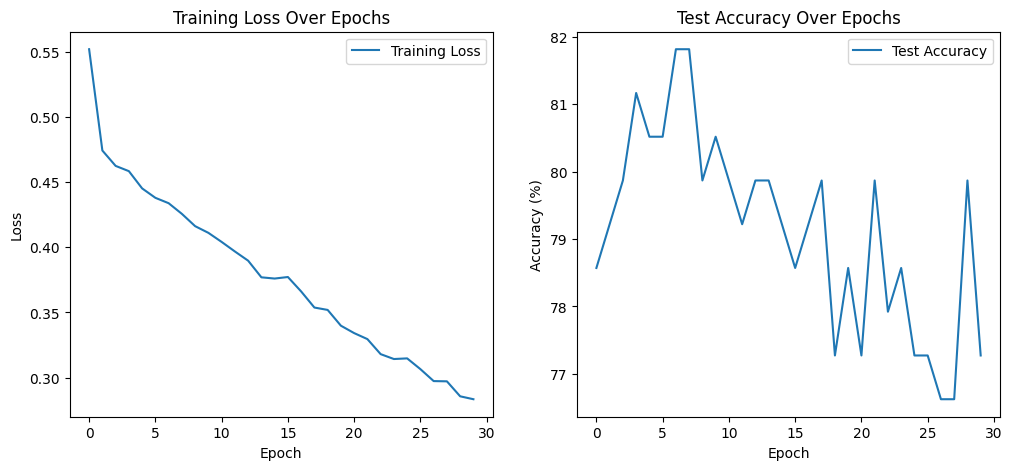

In [64]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

In [65]:
# 데이터와 타겟 분리
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

In [66]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

data_array = np.hstack((X, y.reshape(-1, 1)))

data_array.shape

(768, 9)

In [67]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 5
X, y = split_sequences(data_array, n_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((611, 5, 8), (611,), (153, 5, 8), (153,))

In [72]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class DiabetesCNN(nn.Module):
    def __init__(self):
        super(DiabetesCNN, self).__init__()
        self.conv1 = nn.Conv1d(8, 16, kernel_size=3, padding=1)  # Change input channels to 6
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 5, 64)  # Adjust the linear layer input size accordingly
        self.fc2 = nn.Linear(64, 2)  # 2 classes in the dataset
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = DiabetesCNN()
summary(model, input_size=(8, 5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]             400
            Conv1d-2                [-1, 32, 5]           1,568
            Linear-3                   [-1, 64]          10,304
            Linear-4                    [-1, 2]             130
Total params: 12,402
Trainable params: 12,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


C:\Users\user\AppData\Local\Temp\ipykernel_132\3913651910.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_132\3913651910.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.int64)
C:\Users\user\AppData\Local\Temp\ipykernel_132\3913651910.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_132\3913651910.p

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_accuracies = []

Epoch 1/20, Loss: 0.6460, Accuracy: 62.75%
Epoch 2/20, Loss: 0.6352, Accuracy: 62.75%
Epoch 3/20, Loss: 0.5828, Accuracy: 64.05%
Epoch 4/20, Loss: 0.5428, Accuracy: 72.55%
Epoch 5/20, Loss: 0.4804, Accuracy: 74.51%
Epoch 6/20, Loss: 0.4457, Accuracy: 72.55%
Epoch 7/20, Loss: 0.4563, Accuracy: 75.16%
Epoch 8/20, Loss: 0.4679, Accuracy: 75.16%
Epoch 9/20, Loss: 0.4086, Accuracy: 74.51%
Epoch 10/20, Loss: 0.4198, Accuracy: 75.82%
Epoch 11/20, Loss: 0.3720, Accuracy: 75.82%
Epoch 12/20, Loss: 0.3663, Accuracy: 72.55%
Epoch 13/20, Loss: 0.3413, Accuracy: 74.51%
Epoch 14/20, Loss: 0.3286, Accuracy: 74.51%
Epoch 15/20, Loss: 0.3170, Accuracy: 74.51%
Epoch 16/20, Loss: 0.2975, Accuracy: 72.55%
Epoch 17/20, Loss: 0.2806, Accuracy: 75.16%
Epoch 18/20, Loss: 0.2957, Accuracy: 73.20%
Epoch 19/20, Loss: 0.2618, Accuracy: 74.51%
Epoch 20/20, Loss: 0.2319, Accuracy: 75.16%
Training complete.
Confusion Matrix:
[[80 16]
 [22 35]]
F1 Score: 0.75
Precision: 0.75
Recall: 0.75
Specificity: 0.72


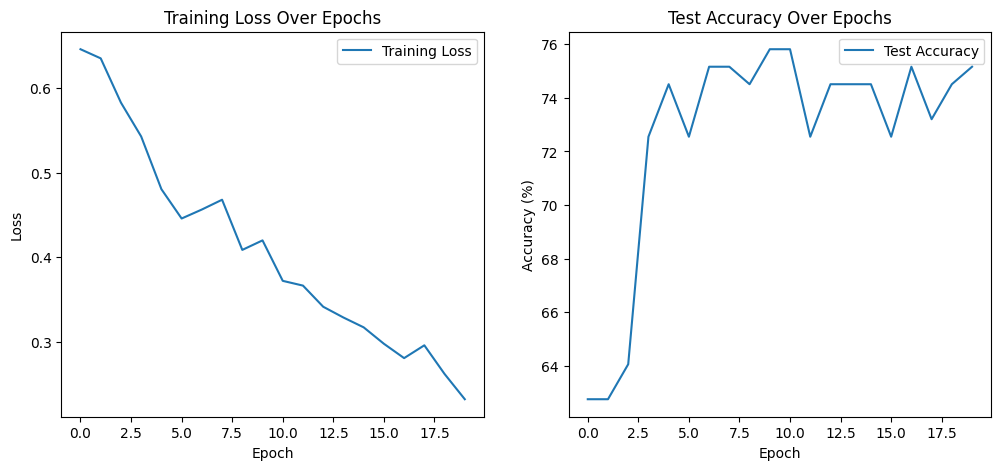

In [74]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()

        # Forward
        inputs = inputs.permute(0, 2 ,1) #(배치크기, 채널, 실행길이)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # epoch
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.permute(0, 2, 1)#(배치크기, 채널, 실행길이)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

#numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()